EPITA 2019 MLRF practice_03-01_ORB_AR v2019-05-19_233542 by Joseph CHAZALON

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Practice 03 part 01: Augmented Reality using ORB matching

We will demonstrate a simple technique, light enough to be run on an old smartphone, which detects an instance of a know document in a video frame, and overlays some dynamic content over this document in the frame.

We will use an excerpt of a dataset we created for a funny little app a few years ago, which allows children to point at a songbook page and play the associated song using a tablet. This is illustrated below.
 

![AR example](img/practice_03/AR2.jpg)

This is much like marker-based Augmented Reality (AR), where the marker is a complex image.

**This approach requires to prepare of document model prior to matching documents within frames.**

We will proceed in 5 steps:

1. detect keypoints from the model and display them;
2. compute the descriptors for the model image;
3. detect the keypoints for a frame image, compute the descriptors and display them;
4. create matchers and index descriptors;
5. estimate the homography from the model to the frame;
5. project a modified image over the document in the frame.

The resources for this session are packaged directly within this notebook's archive: you can access them under the `resources/` folder:
- `model.png`: the model image we will use;
- `frame_0010.jpeg`: a frame image extracted from a video.

## 0. Import module, load resources

In [1]:
# deactivate buggy jupyter completion
%config Completer.use_jedi = False

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [3]:
PATH_TO_RESOURCES = "./resources"

In [4]:
model_img = cv2.imread(os.path.join(PATH_TO_RESOURCES, "model.png"))
model_img.shape, model_img.dtype

((1654, 2340, 3), dtype('uint8'))

In [5]:
# to remain sane
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Here is our model image

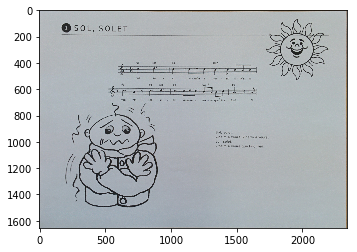

In [6]:
plt.imshow(bgr2rgb(model_img), cmap='gray')

We need to convert it to grayscale to extract ORB keypoints from it.

In [7]:
model_img_gray = cv2.cvtColor(model_img, cv2.COLOR_BGR2GRAY)

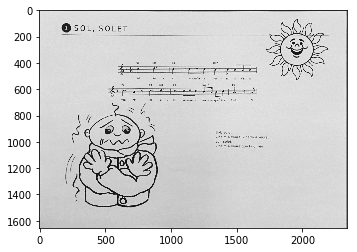

In [8]:
plt.imshow(model_img_gray, cmap='gray')

### Here is the frame we will process

In [9]:
frame_img = cv2.imread(os.path.join(PATH_TO_RESOURCES, "frame_0010.jpeg"))
frame_img.shape, model_img.dtype

((1080, 1920, 3), dtype('uint8'))

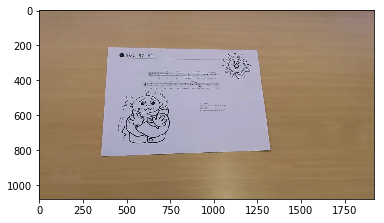

In [10]:
plt.imshow(bgr2rgb(frame_img), cmap='gray')

We also need to convert it to grayscale, for the same reason.

In [16]:
frame_img_gray = cv2.cvtColor(frame_img, cv2.COLOR_BGR2GRAY)

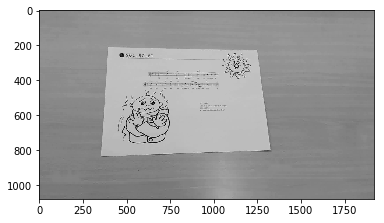

In [17]:
plt.imshow(frame_img_gray, cmap='gray')

## 1. Detect and draw keypoints (model image)
First, we will detect and display some keypoints using the ORB method.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Complete the creation of the ORB object below, setting parameters appropriately.**

*Tips:*
- ORB keypoint detection and description is performed with the same `ORB` object.
- Create this `ORB` object using `cv2.ORB.create(...)`.
- You need to select appropriate parameters. The default parameters may not give the best possible results.
- In particular, we need:
  - a few thousands features;
  - several levels (as the frame object may appear several times smaller than the original model);
  - to select the Harris score to stabilize the results (`scoreType=cv2.ORB_HARRIS_SCORE`).
</div>

In [19]:
# Run me!
cv2.ORB.create?

In [102]:
# TODO create the ORB detector and descriptor
orb = cv2.ORB.create(nfeatures=850, scoreType=cv2.ORB_HARRIS_SCORE) # FIXME

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Now you can detect keypoints from the model image.**

*Tips:*
- Use the `ORB.detect()` method.
- Use the graylevel image.
</div>

In [103]:
# TODO detect keypoints
model_kpts = orb.detect(model_img_gray)# FIXME
len(model_kpts)

850

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Display the keypoints using the function we provide below.**
</div>

In [104]:
# because the function from OpenCV's python wrapper is buggy
def draw_keypoints(color_image, keypoints, color=()):
    '''
    Display keypoints in some color over an image.

    Parameters
    ----------
    color_image: ndarray, shape=(rows, cols, 3 channels)
        color image in BGR order

    keypoints: list of cv2.KeyPoint
        keypoints detected in the image

    color: tuple of uint8 (optional)
        color of the keypoints to drawn, in BGR order
    '''
    if color_image.ndim != 3:
        raise ValueError(
            "draw_keypoints: parameter `color_image` must be a... (wait for it) color image!")
    draw = color_image.copy()
    for k in keypoints:
        angle = k.angle
        class_id = k.class_id
        convert = k.convert
        octave = k.octave
        overlap = k.overlap
        pt_x, pt_y = k.pt
        pt_int = int(pt_x), int(pt_y)
        response = k.response
        size = k.size
        color = (0, 255, 0)
        cv2.circle(draw, pt_int, int(size), color)
        pt2 = int(pt_x + np.sin(angle)*size), int(pt_y + np.cos(angle)*size)
        cv2.line(draw, pt_int, pt2, color, thickness=2)
    plt.imshow(bgr2rgb(draw))

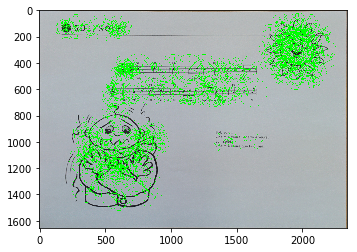

In [105]:
# TODO draw the keypoints detected in the model image
draw_keypoints(model_img, model_kpts) # FIXME

## 2. Compute descriptors (model image)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the descriptors for each of the keypoints we previously detected.**

*Tips:*
- Use the `ORB.compute() method.`
</div>

In [106]:
# TODO compute the descriptors
model_kpts, model_desc = orb.compute(model_img_gray, model_kpts) # FIXME
len(model_kpts), model_desc.shape

(850, (850, 32))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**What is the size (in bytes) of an ORB descriptor?**
</div>

**TODO you answer here**

Storing an ORB descriptor takes ... bytes (without indexing overhead).

## 2. Detect and compute keypoints from the frame

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Using the `ORB.detectAndCompute()` method, preform keypoint detection and description in a single step.**

*Tips:*
- This function requires a mask but we do not need it. Set `mask=None`.
</div>

In [107]:
# TODO detect keypoints and compute descriptors for the frame
frame_kpts, frame_descr = orb.detectAndCompute(frame_img_gray, mask=None)
len(frame_kpts), frame_descr.shape

(850, (850, 32))

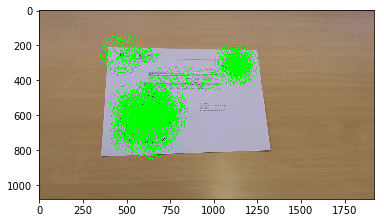

In [108]:
# Run me!
draw_keypoints(frame_img, frame_kpts)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**What are the regions where keypoints are detected?**
</div>

**TODO you answer here**



## 3. Create a matcher and index model descriptors
A matcher object is used to compare two sets of descriptors.

The relevant OpenCV documentation is available at the [DescriptorMatcher documentation page](https://docs.opencv.org/master/db/d39/classcv_1_1DescriptorMatcher.html).

### Overview
There are two matchers available in OpenCV: 
- the brute force matcher, which performs a $m \times n$ match of each of the $m$ descriptors in the first set against each of the $n$ descriptors in the second set;
- the FLANN-based matcher, which performs fast approximate nearest neighbor search using an indexing structure.

In both cases, we need to specifiy the **distance** the matcher will use to compare descriptors.
There are several built-in norms:
- cv2.NORM_INF: $\|X-Y\|_{L_{\infty}} = \max _i | X_i - Y_i|$ where $V_i$ is the $i$-th component of vector $V$.
- cv2.NORM_L1: $\| X-Y \| _{L_1} = \sum _i | X_i - Y_i|$
- cv2.NORM_L2: $\| X-Y \| _{L_2} = \sqrt{\sum_i (X_i - Y_i)^2}$
- cv2.NORM_L2SQR: $\| X-Y \| _{L_2} = \sum_i (X_i - Y_i)^2$
- cv2.NORM_HAMMING: Calculates the Hamming distance (count the non-zero bits in $X_i \mathbin{\&} Y_i$, where $\mathbin{\&}$ is a bit-wise "and") between the arrays.
- cv2.NORM_HAMMING2: Similar to `NORM_HAMMING`, but in the calculation, each two bits of the input sequence will be added and treated as a single bit to be used in the same calculation as `NORM_HAMMING` (only useful if you set the `WTA_K` parameter of ORB to something else than `2`).

### Brute force (BF) matcher
It has only 1 parameter, beside the distance function: `crossCheck`. It allows to perform a symmetry test, ie to keep only descriptors pairs where each one is the closest to the other one in each set, or more formally:
$$
\{
(\hat{d_i},\hat{d_j}) \mid
\hat{d_j} = \underset{d_j \in D_2}{\mathrm{argmin}} \operatorname{dist}(\hat{d_i}, d_j)
\land
\hat{d_i} = \underset{d_i \in D_1}{\mathrm{argmin}} \operatorname{dist}(d_i, \hat{d_j})
\},
$$
otherwise, we get the following set, $\forall d_i \in D_1$:
$$
\{
(d_i,\hat{d_j}) \mid
\hat{d_j} = \underset{d_j \in D_2}{\mathrm{argmax}} \operatorname{score}(d_i, d_j)
\}.
$$

We recommend to create a BF matcher using `cv2.BFMatcher_create(normType, crossCheck)`.

### FLANN-based matcher
FLANN stands for Fast Library for Approximate Nearest Neighbors.

The FLANN-based matcher is much more complex than the BF one, as it can use multiple indexing strategies 
(which may or may not be compatible with your descriptor type!) which have, in turn, parameters to be set.

This matcher may be faster when matching a large train collection than the brute force matcher.

A good but old documentation is available for 
[OpenCV 2.4 implementation](https://docs.opencv.org/2.4/modules/flann/doc/flann_fast_approximate_nearest_neighbor_search.html).

OpenCV supports several indexing algorithms:
- Linear: the index will perform a linear, brute-force search.
  - algorithm code: FLANN_INDEX_LINEAR = 0
  - no extra parameters
- KD-Trees: the index constructed will consist of a set of randomized kd-trees which will be searched in parallel.
  - algorithm code: FLANN_INDEX_KDTREE = 1
  - extra parameters: `trees` The number of parallel kd-trees to use. Good values are in the range `[1..16]`.
- K-Means: the index constructed will be a hierarchical k-means tree.
  - algorithm code: FLANN_INDEX_KMEANS = 2
  - extra parameters include the branching factor to use for the hierarchical k-means tree, 
  and parameters for K-Means initialization and computation.
- Composite: the index created combines the randomized kd-trees and the hierarchical k-means tree.
  - algorithm code: FLANN_INDEX_COMPOSITE = 3
  - extra parameters include both previous parameters sets.

- KD-Tree: the index is contructed using a single KD-tree.
  - algorithm code: FLANN_INDEX_KDTREE_SINGLE = 4
  - extra parameters: None, apparently
- Hierarchical clustering: Documentation is missing, but it seems to be a classical hierarchical clustering.
  - algorithm code: FLANN_INDEX_HIERARCHICAL = 5
  - extra parameters: unclear
- LSH (Locality Sensitive Hashing): the index created uses multi-probe LSH.
  - algorithm code: FLANN_INDEX_LSH = 6
  - **This indexing algorithm is compatible with ORB's binary descriptors!**
  - extra parameters:
    - `table_number`: the number of hash tables to use (between 10 and 30 usually).
    - `key_size`: the size of the hash key in bits (between 10 and 20 usually).
    - `multi_probe_level`: the number of bits to shift to check for neighboring buckets (0 is regular LSH, 2 is recommended).
  - Also, [this tutorial](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html) suggests to use the following parameters:
      - `table_number = 6`
      - `key_size = 12`
      - `multi_probe_level = 1`
- and [even more](https://github.com/opencv/opencv/blob/b39cd06249213220e802bb64260727711d9fc98c/modules/flann/include/opencv2/flann/defines.h#L68)…

This matcher also has search parameters (like whether to sort the results) but there are very little reasons to change the default values.

To create a FLANN-based matcher, we recommend to use the following technique:
```python
# Create a dictionary for indexing parameters:
flann_index_params= dict(algorithm = 6, # LSH
                        table_number = 6, # LSH parameters
                        key_size = 12,
                        multi_probe_level = 1)
# Then create the matcher
matcher = cv2.FlannBasedMatcher(indexParams=flann_index_params)
```


<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create a BF matcher and FLANN matcher.**
</div>

In [109]:
# TODO
matcher_BF = cv2.BFMatcher_create(cv2.NORM_HAMMING)
matcher_FLANN = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

### Indexation
While it is possible to directly call  `matcher.match(descriptors1, descriptors2)`,
we usually index descriptors before matching them.

This is useful in real conditions for the case we are working on: we have to match each frame against every possible model (there were severa songs available), so this allows to:
1. perform indexing only once;
2. handle multiple models and therefore perform object detection (however the pipeline is a bit more complex).

This is performed using the `matcher.add(list_of_list_of_descriptors)` 
which adds sets of descriptors for several **training (or "model") images**.

The index then retains for each single descriptor:
- its value (indexed);
- the id of the training image.

We will therefore distinguish between:
- **train descriptors**, provided upon training;
- **query descriptors**, provided upon matching.


<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Index the descriptors of the model image.**

*Tips:*
- Use `matcher.add()`.
- Do it for both matchers (we will compare them).
- **add() takes a list of list of descriptors!**
</div>

In [110]:
# TODO
matcher_BF.add((frame_descr, model_desc))
# matcher_FLANN.add(...)

## 4. Match descriptors and estimate the homography
We are now ready to match descriptors.

We suggest to use a FLANN-based matcher to be able to perform a ratio-test.

### Matching descriptors
Matching descriptors is performed using one of the following functions:

- `matcher.match(query_descriptors)`: actually is `knnMatch`, with `k=1`.
- `matcher.knnMatch(query_descriptors, k=...)`: 
  Performs a K-nearest neighbor search for a given query point using the index.
  - Without symmetry test, this will return a match for each query descriptor as long as there is at least one descriptor in the train set.
  - Useful for ratio test with `k` > 1.
  - Note that `k` > 1 is not possible with BF matcher when `crossCheck` is `True`!
- `matcher.radiusMatch(query_descriptors, maxDistance=...)`: 
  Performs a radius nearest neighbor search for a given query point, ie returning only results within the specified radius).
  - Useful with when we have a background model which allows us to set a threshold.

### 4.1 Simple match

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the matches between the frame descriptors and the model descriptors using the FLANN matcher.**

*Tips:*
- Use the `matcher.match()` method to avoid having a list of tuples of 1 element as result.
</div>

In [111]:
# TODO compute the matches
matches = matcher_BF.match(model_desc, frame_descr)
len(matches)

850

### Display the matches
Here is a simple way to display the matches using `cv2.drawMatches()`.
We could keep only the closest matches, but we will keep this simple for now.

In [112]:
# Run me
def draw_matches(img1, kpts1, img2, kpts2, matches, color=(0,0,255), title=""):
    '''img1 and img2 are color images.'''
    img_matches = np.empty((max(img1.shape[0], img2.shape[0]),
                           img1.shape[1]+img2.shape[1], 
                           3), 
                           dtype=np.uint8)
    img_matches = cv2.drawMatches(img1, model_kpts, img2, kpts2, 
                          matches, 
                          img_matches,
                          matchColor=color,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12,4))
    plt.imshow(bgr2rgb(img_matches))
    plt.title(title + " - %d matches" % (len(matches),))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Draw those first matches (frame → model) in RED.**
</div>

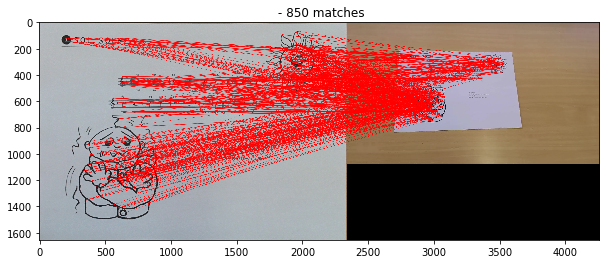

In [113]:
# TODO draw the first matches
draw_matches(model_img, model_kpts, frame_img, frame_kpts, matches)

### 4.2 Symmetry test
Let us now use the BF matcher to ask for a cross check.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the matches using a symmetry test and display them in BLUE.**
</div>

In [ ]:
# TODO
# matches = ...
# draw_matches(...)

### 4.3 Ratio test
Let's stop using the BF matcher now, and **use the FLANN matcher for what remains.**

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the matches using the FLANN-based matcher, asking for the 2 nearest neighbors.**
</div>

In [ ]:
# TODO
# matches = ...

### Match results

The result of `matches = matcher.match*(query_descriptors)` line is a list of `DMatch` objects. 
A `DMatch` object has following attributes:
- `DMatch.distance`: Distance between descriptors. The lower, the better it is.
- `DMatch.trainIdx`: Index of the descriptor in train descriptors
- `DMatch.queryIdx`: Index of the descriptor in query descriptors
- `DMatch.imgIdx`: Index of the train image.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Filter the matches using a ratio test.**

*Tips:*
- This means, $\forall \texttt{m},\texttt{n} \in M$ keep $\texttt{m}$ only if $\texttt{m.distance} < \texttt{n.distance} * T$ where $T$ is the ratio test value.
</div>

In [ ]:
# TODO filter matches
# good_matches = ...
# len(good_matches)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Draw those good matches (frame → model) with ratio test in CYAN.**
</div>

In [ ]:
# TODO
# draw_matches(...)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compare the filtering of the symmetry test and the ratio test: which one rejects more matches?**
</div>

TODO write your answer here

### 4.4 Geometric validation
Finally, using the good matches we computed using the ratio test, we can estimate the perspective transform between the model and the frame (in this direction, because we will project a modified model image over the scene/frame).

First we need to build two corresponding lists of point coordinates, for the source and for the destination.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Extract the point coordinates of the good matches to build two list of corresponding coordinates in the model and in the frame referentials.**

*Tips:*
- Recover the index of the keypoints using either `m.trainIdx` or `m.queryIdx`.
- Extract the point coordinates from each keypoint using `kpts[INDEX].pt`.
</div>

In [ ]:
# prof
pts_mdl = []
pts_frame = []
# for m in good_matches:
#     # TODO
len(pts_mdl), len(pts_frame)

As the RANSAC implementation in OpenCV requires float numbers, we will convert our coordinates.

In [ ]:
# Run me
pts_mdl, pts_frame = np.float32(pts_mdl), np.float32(pts_frame)

We are now ready to estimate the homography using RANSAC.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Use `cv2.findHomography()` to estimate the homography from the model to the frame.**

*Tips:*
- The constant to use the RANSAC method is `cv2.RANSAC`.
- `3` is a good value for the RANSAC retroprojection error threshold which rejects point pairs if
$$
\| \texttt{dstPoints} _i -  \texttt{convertPointsHomogeneous} ( \texttt{H} * \texttt{srcPoints} _i) \|_2
>  \texttt{ransacReprojThreshold}.
$$
</div>

In [ ]:
cv2.findHomography?

In [ ]:
# TODO
# H, pts_inliers_mask = cv2.findHomography(...)
# H

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Filter the good matches to keep only the RANSAC inliers.**

*Tips:*
- `pts_inliers_mask` indicates which point pairs are inliers.
</div>

In [ ]:
# TODO 
# matches_ransac_inliers = ...
# len(matches_ransac_inliers)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Draw those good inlier matches (frame → model) with ratio test and RANSAC in GREEN.**
</div>

In [ ]:
# TODO
# draw_matches(...)

## 5. Simple AR
Finally, we can project some image over the frame.

### Model quadrilateral

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Define an array of shape `(1, 4, 2)` and type `np.float32` to represent the coordinates of the 4 corners of the model.**
</div>

In [ ]:
# TODO
# model_quad = np.float32([[[0, 0],
#                          ...]])

### Frame quadrilateral

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Now use `cv2.perspectiveTransform()` to compute the coordinates of the model corners within the frame referential.**
</div>

In [ ]:
# TODO
# frame_quad = cv2.perspectiveTransform(...)
# frame_quad

### Draw the object outline

We can now draw the detected object over the frame.

In [ ]:
dbg_img = frame_img.copy()
cv2.polylines(dbg_img, np.int32(frame_quad), True, (0, 255, 0), 10)
plt.imshow(bgr2rgb(dbg_img))

### Project a modifier model image on the scene (the frame)
Let us use a very simple modified model image, to indicate we detected it:

In [ ]:
model_img_modified = np.uint8(model_img * (1,1,0))
plt.imshow(bgr2rgb(model_img_modified))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Use `cv2.warpPerspective()` to project `model_img_modified` onto the frame's referential.**

*Tips:*
- **Warning:** the `dsize` takes a `tuple(int, int)` in the form `(num_columns, num_rows)`, and **not** `(rows, cols)` as in the shape of a row-major NumPy array!

</div>

In [ ]:
cv2.warpPerspective?

In [ ]:
# TODO
# warped_img = cv2.warpPerspective(...)
# plt.imshow(bgr2rgb(warped_img))

We need to use a mask to blend this warped image with the original frame.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create a mask with `np.zeros` and fill the right region using `cv2.fillPoly()`.**
</div>

In [ ]:
cv2.fillPoly?

In [ ]:
# TODO
# warped_img_msk= np.zeros(...)
# warped_img_msk = cv2.fillPoly(...)
# plt.imshow(warped_img_msk)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Finally, overlay the modified image over the frame.**
</div>

In [ ]:
# TODO

## BONUS Mobile document scanner
Assume you have the four coordinates of the corners of the documents in the frame (they are in `frame_quad.squeeze()`), and that it is a landscape A4 page (you have its corners in `model_quad.squeeze()`), create a dewarped (cropped, without perspective) document image.

Said differently: Knowing the model shape, from the coordinates of the object
![Input](img/practice_03/bonus-input.png)

produce the following cropper image:
![output](img/practice_03/bonus-result.png)


Hints:
- use `cv2.getPerspectiveTransform`

Extra kudos:
- adjust the size of the output image depending on the area on the frame.